In [11]:
from typing import Generator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numba import njit
from numba.typed import List
import numpy as np
from tqdm import tqdm
import seaborn as sns

import target_io
import make_clean_showers as mcs
from apply_gains import apply_gains

sns.set_style("whitegrid")

In [2]:
mod_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 103, 106, 107,
            108, 111, 112, 114, 115, 119, 121, 123, 124, 125, 126]

mod_nums = [100, 111, 114, 107, 6, 115, 123, 124, 112, 7, 119,
            108, 110, 121, 8, 103, 125, 126, 106, 9, 4, 5, 1, 3, 2]
fpm_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24]

fpm_pos = np.mgrid[0:5, 0:5]
fpm_pos = zip(fpm_pos[0].flatten(), fpm_pos[1].flatten())

mod_to_fpm = dict(zip(mod_nums, fpm_nums))
fpm_to_pos = dict(zip(fpm_nums, fpm_pos))

ch_nums = np.array([[21, 20, 17, 16, 5, 4, 1, 0],
                    [23, 22, 19, 18, 7, 6, 3, 2],
                    [29, 28, 25, 24, 13, 12, 9, 8],
                    [31, 30, 27, 26, 15, 14, 11, 10],
                    [53, 52, 49, 48, 37, 36, 33, 32],
                    [55, 54, 51, 50, 39, 38, 35, 34],
                    [61, 60, 57, 56, 45, 44, 41, 40],
                    [63, 62, 59, 58, 47, 46, 43, 42]])
rot_ch_nums = np.rot90(ch_nums, k=2)
ch_to_pos = dict(zip(ch_nums.reshape(-1), np.arange(64)))
rot_ch_to_pos = dict(zip(rot_ch_nums.reshape(-1), np.arange(64)))

num_columns = 5
total_cells = num_columns * num_columns * 64
indices = np.arange(total_cells).reshape(-1, int(np.sqrt(total_cells)))
grid_ind = List()
for index, mod in enumerate(mod_list):
    i, j = fpm_to_pos[mod_to_fpm[mod]]
    ch_map = dict()
    if j % 2 == 0:
        ch_map = rot_ch_to_pos
    else:
        ch_map = ch_to_pos
    # print(f"Channel Map: {ch_map}")
    j = num_columns - 1 - j
    pix_ind = np.array(indices[
        (8*i):8*(i+1), (8*j):8*(j+1)]).reshape(-1)
    # print(f"Pixel Index: {pix_ind}")
    for asic in range(4):
        for ch in range(16):
            grid_ind.append(int(pix_ind[
                ch_map[asic * 16 + ch]]))

In [3]:
calfile = "/data/wipac/CTA/target5and7data/runs_320000_through_329999/cal328555.r1"
reader = target_io.WaveformArrayReader(calfile)
n_pixels = reader.fNPixels
n_samples = reader.fNSamples
n_events = reader.fNEvents
waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
image = np.zeros((40, 40))
peaks = np.zeros((40, 40))
ev = 6307
reader.GetR1Event(ev, waveforms)
waveforms = apply_gains(waveforms)
peak_position = np.argmax(waveforms, axis=1)
charge = mcs.calculate_charge(waveforms, peak_position, n_samples)
for wf in waveforms:
    peaks[grid_ind[i]%40, grid_ind[i]//40] = np.max(wf)
for i, val in enumerate(charge):
    image[grid_ind[i]%40, grid_ind[i]//40] = val

In [41]:
@njit
def get_bright_coordinates(peaks: np.ndarray) -> List:
    bright_coordinates = List()
    for i in range(peaks.shape[0]):
        for j in range(peaks.shape[1]):
            if peaks[i, j] > 2.5:
                bright_coordinates.append((i, j))
    return bright_coordinates

In [42]:
@njit
def n_reversed(list_: np.ndarray) -> int:
    i = len(list_)
    while i > 0:
        i -= 1
        yield list_[i]

In [43]:
#@njit
def pairs(tup_list: List):
    #print(tup_list)
    pool = tup_list
    n = len(pool)
    r = 2
    if r > n:
        return
    indices = np.arange(r)
    temp = List()
    for i in indices:
        temp.append(pool[i])
    #temp = tuple(temp)
    yield temp
    #yield tuple(pool[i] for i in indices)
    while True:
        for i in n_reversed(np.arange(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        #yield tuple(pool[i] for i in indices)
        temp = List()
        for i in indices:
            temp.append(pool[i])
        #temp = tuple(temp)
        yield temp

In [44]:
def is_noise(peaks: np.ndarray) -> bool:
    bright_coords = get_bright_coordinates(peaks)
    count = 0
    for pair in pairs(bright_coords):
        x_dist = np.abs(pair[0][0] - pair[1][0])
        y_dist = np.abs(pair[0][1] - pair[1][1])
        dist = np.sqrt(x_dist ** 2 + y_dist ** 2)
        if dist < np.sqrt(2):
            #print(pair)
            count += 1
        if count == 4:
            break
    if count < 4:
        return True
    else:
        return False

In [45]:
is_noise(peaks)

True

In [53]:
%%time
not_noise = []
run = 328555
count = 0
for ev in range(1000):
    ev = int(ev)
    reader.GetR1Event(ev, waveforms)
    waveforms = apply_gains(waveforms)
    for i, wf in enumerate(waveforms):
        peaks[grid_ind[i]%40, grid_ind[i]//40] = np.amax(wf[30:])
    noise = is_noise(peaks)
    if noise is False:
        count += 1
        not_noise.append(ev)
        peak_position = np.argmax(waveforms, axis=1)
        charge = mcs.calculate_charge(waveforms, peak_position, n_samples)
        for i, val in enumerate(charge):
            image[grid_ind[i]//40, grid_ind[i]%40] = val
        #if count % 2 == 0:
        #camera_image(image, run, ev)
        #plt.show()

CPU times: user 43.6 s, sys: 236 ms, total: 43.9 s
Wall time: 43.8 s


In [54]:
print(len(not_noise))

52


In [27]:
%matplotlib inline
def camera_image(image, run, ev, keep=False):
    maxZ = np.nanmax(image)
    fig = plt.gcf()
    if fig.get_size_inches().all() == np.array([18., 15.]).all():
        plt.close(fig)
        fig = plt.figure(figsize=(18, 15))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.04, hspace=0.04)

    for i in range(5):
        for j in range(5):
            sub_image = image[i*8:i*8+8, j*8:j*8+8]
            ax = plt.subplot(gs[4 - i, j])
            c = ax.pcolormesh(sub_image, vmin=0, vmax=maxZ, cmap="viridis")
            ax.axis("off")
            ax.set_aspect("equal")

    fig.subplots_adjust(right=0.8, top=0.9, bottom=0.1)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(c, cax=cbar_ax)
    cbar.set_label("Charge (Photoelectrons)", rotation=270,
                   size=24, labelpad=24)
    cbar_ax.tick_params(labelsize=20)
    fig.suptitle(f"Run {run} Event {ev}", fontsize=30)

In [55]:
%%time
charge_data = []
for ev in range(5000):
    ev = int(ev)
    reader.GetR1Event(ev, waveforms)
    waveforms = apply_gains(waveforms)
    for i, wf in enumerate(waveforms):
        peaks[grid_ind[i]%40, grid_ind[i]//40] = np.amax(wf[30:])
    noise = is_noise(peaks)
    if noise is True:
        peak_position = np.argmax(waveforms, axis=1)
        charge = mcs.calculate_charge(waveforms, peak_position, n_samples)
        charge_data.append(charge)
        #if count % 2 == 0:
        #camera_image(image, run, ev)
        #plt.show()
charge_data = np.asarray(charge_data)
pixel_charge = charge_data.T
noise_averages = np.mean(pixel_charge, axis=1)

CPU times: user 3min 38s, sys: 2.07 s, total: 3min 40s
Wall time: 3min 40s


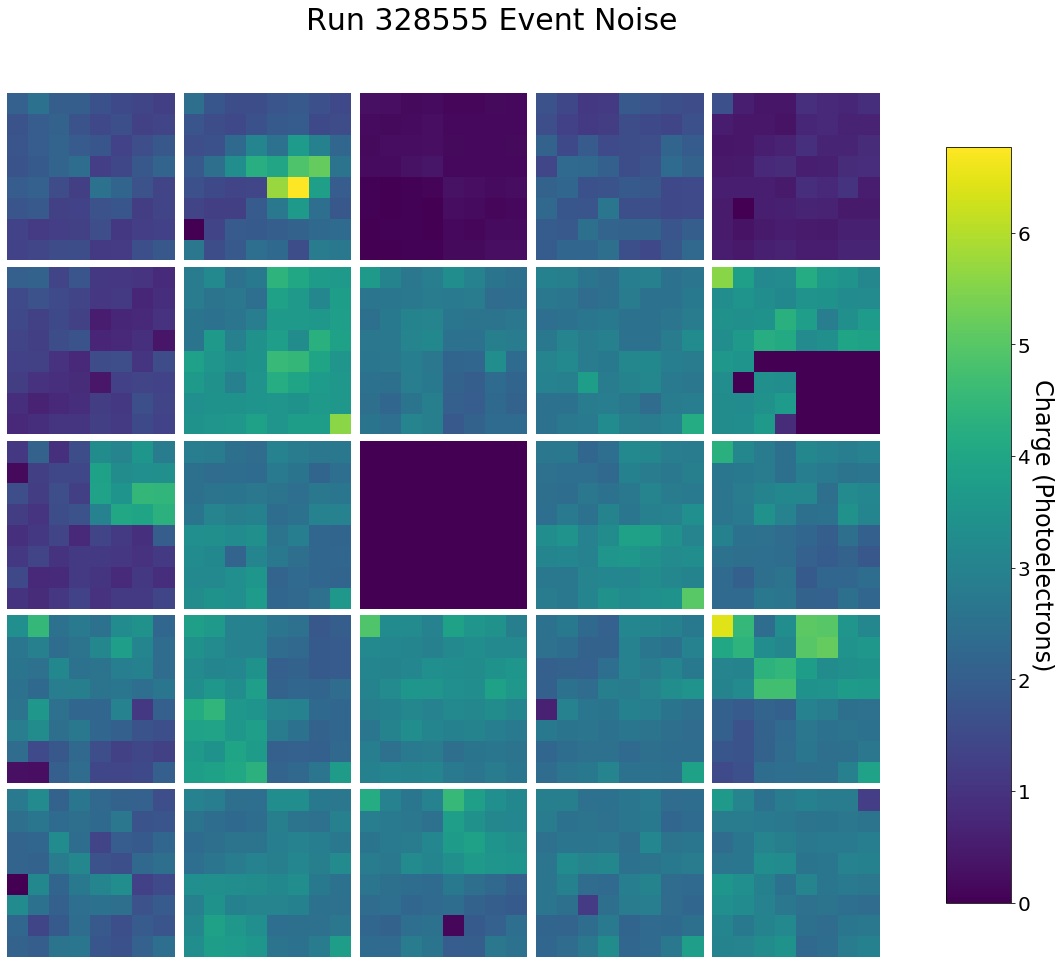

In [56]:
noise_image = np.zeros((40, 40))
for i, val in enumerate(noise_averages):
    noise_image[grid_ind[i]//40, grid_ind[i]%40] = val
camera_image(noise_image, 328555, "Noise")
plt.show()

In [77]:
@njit
def clean_image(raw_charge: np.ndarray, grid_ind: List, mean_noise: np.ndarray) -> np.ndarray:
    # constant values relating to the proportion of a square covered
    # by part of a circle
    a = 0.2138
    b = 0.479
    c = 0.985

    # corresponds to an aperture with 2 pxl radius
    aperture = [[0., a, b, a, 0.],
                [a, c, 1., c, a],
                [b, 1., 1., 1., b],
                [a, c, 1., c, a],
                [0., a, b, a, 0.]]
    aperture = np.asarray(aperture)
    charge_temp = np.zeros((40, 40))
    for i, val in enumerate(raw_charge):
        charge_temp[grid_ind[i]//40, grid_ind[i]%40] = val
    
    noise_temp = np.zeros((40, 40))
    for i, val in enumerate(mean_noise):
        noise_temp[grid_ind[i]//40, grid_ind[i]%40] = val

    # charge = np.pad(charge, (2,), constant_values=(0,)
    charge = np.zeros((44, 44))
    charge[2:42, 2:42] = charge_temp
    
    noise_pad = np.zeros((44, 44))
    noise_pad[2:42, 2:42] = noise_temp

    image = np.zeros((40, 40))
    for i in range(40):
        for j in range(40):
            if charge[i+2, j+2] == 0.0:
                image[i, j] = np.NaN
                continue
            s = np.nansum(charge[i:i+5, j:j+5] * aperture)
            noise = np.nansum(noise_pad[i:i+5, j:j+5] * aperture)
            #if s / mean_noise[j, i] > 50:
            if s > noise*7:
                image[i, j] = charge[i+2, j+2]

    return image

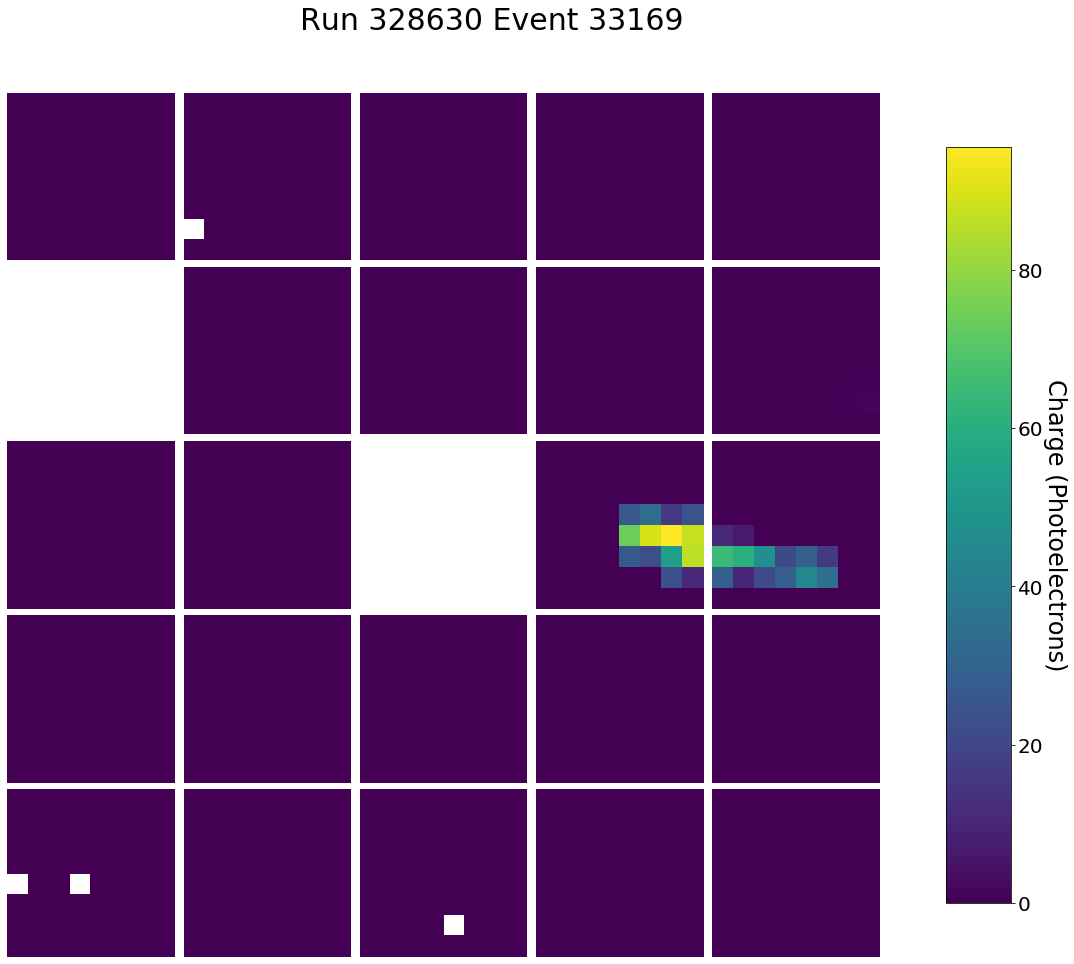

In [79]:
run = 328630
event = 44217
event = 33169
calfile = "/data/wipac/CTA/target5and7data/runs_320000_through_329999/cal328630.r1"
reader = target_io.WaveformArrayReader(calfile)
n_pixels = reader.fNPixels
n_samples = reader.fNSamples
n_events = reader.fNEvents
reader.GetR1Event(event, waveforms)
peak_position = np.argmax(waveforms, axis=1)
charge = mcs.calculate_charge(waveforms, peak_position, n_samples)
charge = apply_gains(charge)
image = clean_image(charge, grid_ind, noise_averages)
camera_image(image, run, event)
plt.show()

In [81]:
run = 328555
calfile = "/data/wipac/CTA/target5and7data/runs_320000_through_329999/cal328630.r1"
reader = target_io.WaveformArrayReader(calfile)
n_pixels = reader.fNPixels
n_samples = reader.fNSamples
n_events = reader.fNEvents
waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
noise = []
not_noise = []
dropped = []
for ev in tqdm(range(n_events)):
    ev = int(ev)
    reader.GetR1Event(ev, waveforms)
    waveforms = apply_gains(waveforms)
    peak_position = np.argmax(waveforms, axis=1)
    charge = mcs.calculate_charge(waveforms, peak_position, n_samples)
    dropped_packets = [zero for zero in charge if zero == 0.0]
    if len(dropped_packets) > 700:
        dropped.append(ev)
        continue
    for i, wf in enumerate(waveforms):
        peaks[grid_ind[i]%40, grid_ind[i]//40] = np.amax(wf[30:])
    noise_bool = is_noise(peaks)
    if noise_bool is True:
        noise.append(ev)
        continue
    if noise_bool is False:
        not_noise.append(ev)

100%|██████████| 237322/237322 [4:08:18<00:00, 15.93it/s]  


In [84]:
np.savez("noise", np.asarray(noise))
np.savez("not_noise", np.asarray(not_noise))
np.savez("dropped", np.asarray(dropped))

In [3]:
noise = np.load("noise.npz")
not_noise = np.load("not_noise.npz")
dropped = np.load("dropped.npz")

In [9]:
noise = noise['arr_0']
not_noise = not_noise['arr_0']
dropped = dropped['arr_0']

In [12]:
run = 328555
calfile = f"/data/wipac/CTA/target5and7data/runs_320000_through_329999/cal{run}.r1"
reader = target_io.WaveformArrayReader(calfile)
n_pixels = reader.fNPixels
n_samples = reader.fNSamples
n_events = reader.fNEvents
waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
tacks = []
for ev in tqdm(range(n_events)):
    ev = int(ev)
    reader.GetR1Event(ev, waveforms)
    tacks.append(reader.fTACK_time)

100%|██████████| 445586/445586 [27:29<00:00, 270.08it/s]


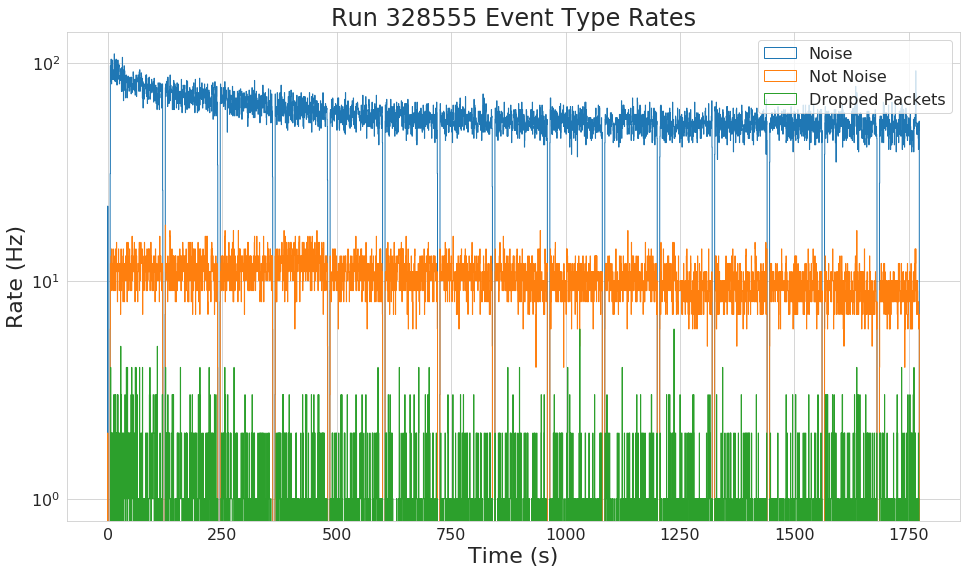

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
noise = np.asarray(noise)
not_noise = np.asarray(not_noise)
bins = tacks[-1] - tacks[0]
timestamp = np.asarray(tacks)
timestamp -= timestamp[0]
timestamp = [time / 1_000_000_000 for time in timestamp]
ax.hist(np.asarray(timestamp)[noise], bins=int(timestamp[-1]), 
        histtype="step", label="Noise")
ax.hist(np.asarray(timestamp)[not_noise], bins=int(timestamp[-1]), 
        histtype="step", label="Not Noise")
ax.hist(np.asarray(timestamp)[np.asarray(dropped)], bins=int(timestamp[-1]), 
        histtype="step", label="Dropped Packets")
ax.legend(loc="upper right", fontsize=16)
ax.set_xlabel("Time (s)", fontsize=22)
ax.set_ylabel("Rate (Hz)", fontsize=22)
ax.set_title("Run 328555 Event Type Rates", fontsize=24)
ax.set_yscale("log")
ax.tick_params(labelsize=16)

In [27]:
a = np.asarray([1, 2, 4, 5, 6])
b = np.asarray([0, 1, 3])
print(a[b])

[1 2 5]


In [30]:
tacks[-1]

3950592356290

In [31]:
tacks[0]

344864983427

In [32]:
tacks[0] - tacks[-1]

-3605727372863